In [1]:
import os
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd
def initialize_firebase():
    """
    Initialize Firebase with fallback credential paths and return a Firestore client.
    """
    # Define your credential paths
    vm_path = r"C:\MasterThesis\Keys.json"
    primary_path = r"C:\Users\sajad\OneDrive\Skole\DevRepos\Master Thesis\Keys.json"
    fallback_path = r"C:\Users\Benja\OneDrive\Skole\DevRepos\Master Thesis\Keys.json"

    if not firebase_admin._apps:
        cred = None
        if os.path.exists(vm_path):
            cred = credentials.Certificate(vm_path)
        elif os.path.exists(primary_path):
            cred = credentials.Certificate(primary_path)
        elif os.path.exists(fallback_path):
            cred = credentials.Certificate(fallback_path)
        else:
            raise FileNotFoundError("Firebase credentials file not found in any of the specified paths.")
        
        firebase_admin.initialize_app(cred)

    return firestore.client()

db = initialize_firebase()


# 🧹 Extract Data from Firestore
def fetch_model_recommendations():
    try:
        collection_ref = db.collection("model_recommendations")
        docs = collection_ref.stream()
        
        data = []
        for doc in docs:
            doc_data = doc.to_dict()
            data.append(doc_data)
        
        # Convert to Pandas DataFrame
        df = pd.DataFrame(data)
        print("✅ Data fetched successfully!")
        return df
    except Exception as e:
        print(f"❌ Error fetching data: {e}")
        return pd.DataFrame()

# Fetch data
df = fetch_model_recommendations()

# Save the data to a CSV file for backup
df.to_csv("model_recommendations.csv", index=False)
print(df.head())

✅ Data fetched successfully!
  stock_ticker                                  sentiment_summary  \
0         NVDA  {'negative': 47.34950000000001, 'neutral': 45....   
1         AAPL  {'negative': 99.60730000000002, 'neutral': 112...   
2         NVDA  {'negative': 61.45169999999999, 'neutral': 56....   
3         MSFT  {'negative': 40.228100000000005, 'neutral': 41...   
4         MSFT  {'negative': 106.76429999999993, 'neutral': 11...   

   latest_close  previous_close  is_correct gpt_recommendation  \
0    133.809799      129.839996        True                Buy   
1           NaN             NaN       False                Buy   
2    131.139999      132.800003       False                Buy   
3    409.940002      415.820007       False                Buy   
4    408.320007      416.130005       False                Buy   

  aggregator_recommendation                   timestamp  experiment_day  \
0                       Buy  2025-02-10T21:57:30.458258              11   
1        

# Quantitative analysis

C:\Users\sajad\AppData\Local\Temp\ipykernel_18568\3315092669.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_counts.index, y=accuracy_counts.values, palette="viridis")


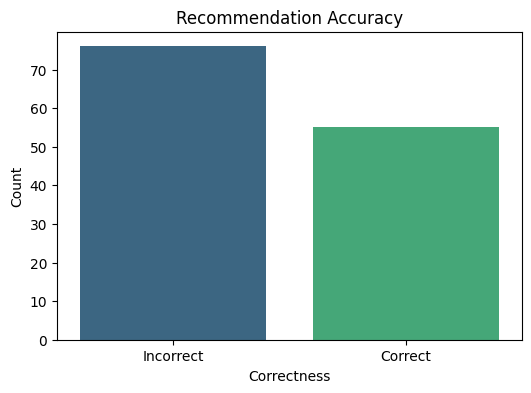

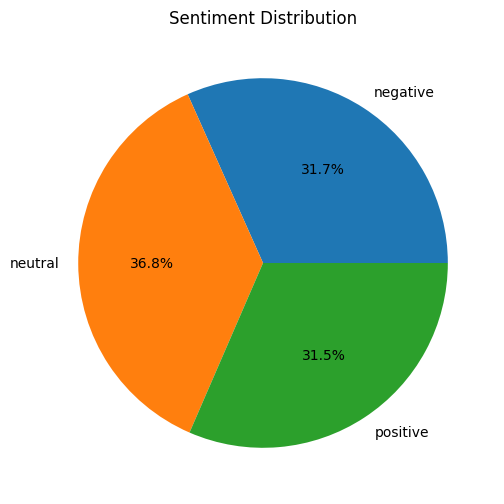

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load data (if not already loaded)
df = pd.read_csv("model_recommendations.csv")

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Analysis: Recommendation Accuracy
accuracy_counts = df['is_correct'].value_counts()

# Visualize Recommendation Accuracy
plt.figure(figsize=(6, 4))
sns.barplot(x=accuracy_counts.index, y=accuracy_counts.values, palette="viridis")
plt.title("Recommendation Accuracy")
plt.xlabel("Correctness")
plt.ylabel("Count")
plt.xticks([0, 1], ["Incorrect", "Correct"])
plt.show()

# Sentiment Summary Distribution
sentiments = df['sentiment_summary'].apply(eval)  # Convert string to dictionary
sentiment_df = pd.json_normalize(sentiments)

# Plot Sentiment Distribution
sentiment_df.sum().plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6), title="Sentiment Distribution")
plt.show()
"

In [3]:
import pandas as pd

def clean_model_recommendations(file_path, output_path):
    # Load dataset
    df = pd.read_csv(file_path)
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Remove duplicates: Keep only the latest recommendation per stock per day
    df['date'] = df['timestamp'].dt.date  # Extract date only
    df = df.sort_values(by=['timestamp'], ascending=False)  # Sort by timestamp
    df = df.drop_duplicates(subset=['stock_ticker', 'date'], keep='first')  # Keep latest entry per stock per day
    df = df.drop(columns=['date'])  # Drop temporary date column
    
    # Remove rows where latest_close or previous_close is missing
    df_cleaned = df.dropna(subset=['latest_close', 'previous_close'])
    
    # Save cleaned data
    df_cleaned.to_csv(output_path, index=False)
    print(f"✅ Cleaned data saved to {output_path}")
    
    return df_cleaned

# Example usage
file_path = "model_recommendations.csv"  # Input CSV file
output_path = "model_recommendations_cleaned.csv"  # Output CSV file
df_cleaned = clean_model_recommendations(file_path, output_path)


✅ Cleaned data saved to model_recommendations_cleaned.csv


C:\Users\sajad\AppData\Local\Temp\ipykernel_18568\3547725819.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_counts.index, y=accuracy_counts.values, palette="viridis")


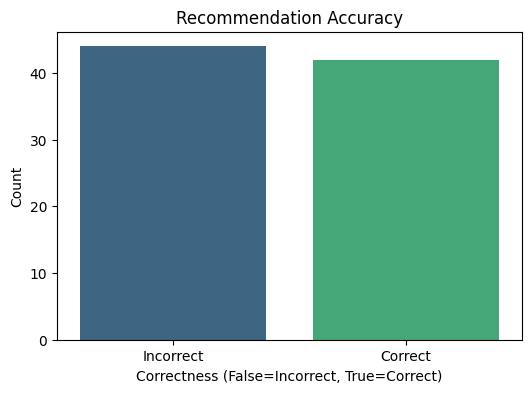

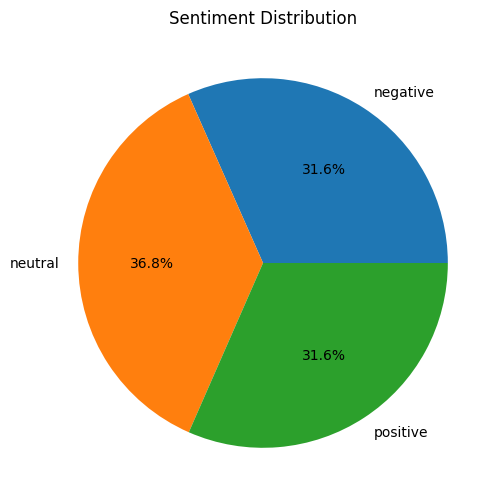

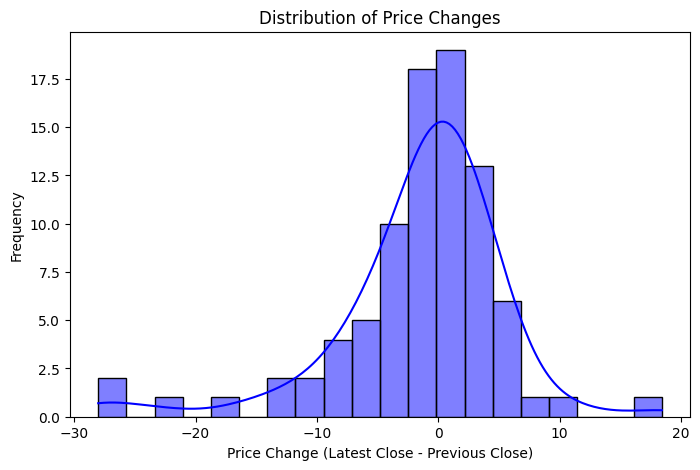

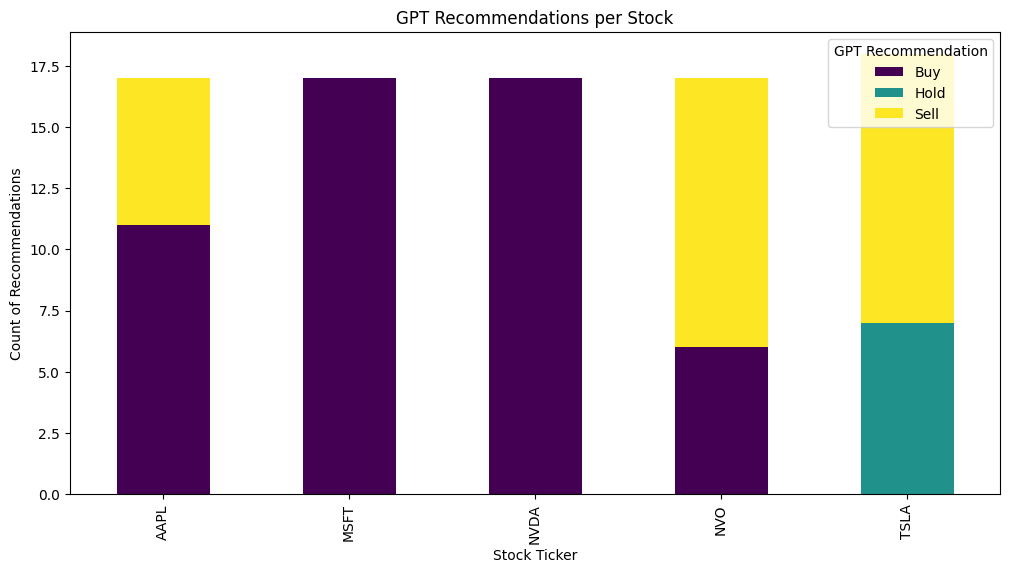

In [4]:
# Define the correct path for the cleaned dataset
cleaned_file_path = "model_recommendations_cleaned.csv"

# Load the cleaned dataset
df_cleaned = pd.read_csv(cleaned_file_path)

# Convert timestamp to datetime
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])

# Re-run the analysis
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Recommendation Accuracy Analysis
accuracy_counts = df_cleaned['is_correct'].value_counts()

# Plot Recommendation Accuracy
plt.figure(figsize=(6, 4))
sns.barplot(x=accuracy_counts.index, y=accuracy_counts.values, palette="viridis")
plt.title("Recommendation Accuracy")
plt.xlabel("Correctness (False=Incorrect, True=Correct)")
plt.ylabel("Count")
plt.xticks([0, 1], ["Incorrect", "Correct"])
plt.show()

# 2. Sentiment Summary Distribution
sentiments = df_cleaned['sentiment_summary'].apply(eval)  # Convert string to dictionary
sentiment_df = pd.json_normalize(sentiments)

# Plot Sentiment Distribution
sentiment_df.sum().plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6), title="Sentiment Distribution")
plt.show()

# 3. Stock Performance: Price Changes
df_cleaned['price_change'] = df_cleaned['latest_close'] - df_cleaned['previous_close']

# Distribution of Price Changes
plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned['price_change'], bins=20, kde=True, color="blue")
plt.title("Distribution of Price Changes")
plt.xlabel("Price Change (Latest Close - Previous Close)")
plt.ylabel("Frequency")
plt.show()

# 4. Recommendations by Stock
stock_recommendation_counts = df_cleaned.groupby("stock_ticker")["gpt_recommendation"].value_counts().unstack()

# Plot Recommendations per Stock
stock_recommendation_counts.plot(kind='bar', figsize=(12, 6), stacked=True, colormap="viridis")
plt.title("GPT Recommendations per Stock")
plt.xlabel("Stock Ticker")
plt.ylabel("Count of Recommendations")
plt.legend(title="GPT Recommendation")
plt.show()


In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

def advanced_analysis(df: pd.DataFrame):
    # STEP 1: Determine correctness based on price movement
    df['price_direction'] = np.where(
        df['latest_close'] > df['previous_close'], 1,
        np.where(df['latest_close'] < df['previous_close'], -1, 0)
    )

    # Map gpt_recommendation → numeric
    def map_recommendation(rec):
        if isinstance(rec, str):
            rec_lower = rec.lower()
            if 'buy' in rec_lower:
                return 1
            elif 'sell' in rec_lower:
                return -1
            elif 'hold' in rec_lower:
                return 0
        return 0

    df['recommendation_numeric'] = df['gpt_recommendation'].apply(map_recommendation)

    # Correctness check
    df['computed_correct'] = (
        (df['recommendation_numeric'] == 1) & (df['price_direction'] == 1) |
        (df['recommendation_numeric'] == -1) & (df['price_direction'] == -1) |
        (df['recommendation_numeric'] == 0) & (df['price_direction'] == 0)
    )

    # STEP 2: Compute Accuracy Rate
    total_predictions = len(df)
    correct_predictions = df['computed_correct'].sum()
    accuracy_rate = correct_predictions / total_predictions if total_predictions else 0

    print(f"Total Predictions: {total_predictions}")
    print(f"Correct Predictions: {correct_predictions}")
    print(f"Accuracy Rate: {accuracy_rate:.2%}")

    # STEP 3: Precision and Recall (Buy/Sell as positive)
    # Create a COPY to avoid SettingWithCopyWarning
    df_buy_sell = df[df['recommendation_numeric'] != 0].copy()
    predicted_positives = len(df_buy_sell)

    df_buy_sell['is_positive_price'] = df_buy_sell['price_direction'] != 0
    df_buy_sell['true_positive'] = (
        df_buy_sell['recommendation_numeric'] == df_buy_sell['price_direction']
    )

    tp = df_buy_sell['true_positive'].sum()
    precision = tp / predicted_positives if predicted_positives else 0

    df_positive_price = df_buy_sell[df_buy_sell['is_positive_price']]
    actual_positives_count = len(df_positive_price)
    tp_among_actual_positives = df_positive_price['true_positive'].sum()
    recall = (
        tp_among_actual_positives / actual_positives_count
        if actual_positives_count
        else 0
    )

    print(f"Precision (Buy/Sell only): {precision:.2%}")
    print(f"Recall (Buy/Sell only): {recall:.2%}")

    # STEP 4: Financial Metrics (Simulated Portfolio Return)
    df_sorted = df.sort_values(by='timestamp').copy()
    df_sorted['next_close'] = df_sorted['latest_close'].shift(-1)

    def simulate_trade(row):
        rec = row['recommendation_numeric']
        if pd.isna(row['next_close']):  # no next day data
            return 0
        if rec == 1:  # Buy
            return (row['next_close'] - row['latest_close']) / row['latest_close']
        elif rec == -1:  # Sell (short-sell)
            return (row['latest_close'] - row['next_close']) / row['latest_close']
        else:
            return 0

    df_sorted['daily_return'] = df_sorted.apply(simulate_trade, axis=1)
    df_sorted['cumulative_return'] = (1 + df_sorted['daily_return']).cumprod() - 1
    final_cumulative_return = df_sorted['cumulative_return'].iloc[-1]
    print(f"Simulated Portfolio Return: {final_cumulative_return:.2%}")

    # STEP 5: Statistical Significance Tests
    # Binomial test (using binomtest for newer SciPy)
    # Compare correctness vs. baseline of 50%
    binom_result = stats.binomtest(
        k=correct_predictions,
        n=total_predictions,
        p=0.5,
        alternative='greater'
    )
    p_value_binom = binom_result.pvalue
    print(f"Binomial test p-value (vs 50% baseline, one-sided): {p_value_binom:.4f}")

    # Z-test
    count = correct_predictions
    nobs = total_predictions
    stat, p_value_ztest = proportions_ztest(count, nobs, value=0.5, alternative='larger')
    print(f"Z-test statistic: {stat:.4f}, p-value: {p_value_ztest:.4f}")

    # Confidence Interval for Accuracy (95% CI)
    alpha = 0.05
    z_crit = stats.norm.ppf(1 - alpha/2)
    phat = accuracy_rate
    se = np.sqrt(phat * (1 - phat) / nobs)
    ci_lower = phat - z_crit * se
    ci_upper = phat + z_crit * se
    print(f"95% CI for Accuracy: [{ci_lower:.2%}, {ci_upper:.2%}]")

    return df_sorted


In [12]:
# 1) Import required libraries
import pandas as pd

# 2) Load the cleaned data
df_cleaned = pd.read_csv("model_recommendations_cleaned.csv")

# 3) Call advanced_analysis on the dataframe
result_df = advanced_analysis(df_cleaned)

# 4) Take a look at the top rows of the result to see daily_return, cumulative_return, etc.
result_df[['timestamp', 'stock_ticker', 'gpt_recommendation',
           'latest_close', 'previous_close',
           'daily_return', 'cumulative_return']].head()


Total Predictions: 86
Correct Predictions: 41
Accuracy Rate: 47.67%
Precision (Buy/Sell only): 51.90%
Recall (Buy/Sell only): 52.56%
Simulated Portfolio Return: -100.00%
Binomial test p-value (vs 50% baseline, one-sided): 0.7050
Z-test statistic: -0.4318, p-value: 0.6671
95% CI for Accuracy: [37.12%, 58.23%]


,timestamp,stock_ticker,gpt_recommendation,latest_close,previous_close,daily_return,cumulative_return
85,2025-01-31 12:08:27.989208,TSLA,Sell,400.279999,389.100006,0.406440,0.406440
84,2025-01-31 12:08:35.829971,AAPL,Sell,237.589996,239.360001,-0.746664,-0.643699
83,2025-01-31 12:08:44.270001,MSFT,Buy,414.989990,442.329987,-0.699631,-0.892978
82,2025-01-31 12:08:51.943009,NVDA,Buy,124.650002,123.699997,-0.315363,-0.926729
81,2025-01-31 12:08:59.475182,NVO,Buy,85.339996,84.029999,3.741036,-0.652619


Reasoned for 7 seconds

Here’s a quick rundown of what each metric indicates and how to interpret them:

    Total Predictions: 86 | Correct Predictions: 41
        Out of 86 Buy/Sell/Hold calls, 41 were correct (according to the “Buy → Price Up, Sell → Price Down” logic).

    Accuracy Rate: 47.67%
        The model’s calls were correct about 48% of the time—below the 50% mark, which is often considered a bare baseline (random guess).

    Precision (Buy/Sell only): 51.90%
        When the model predicted a Buy or Sell (ignoring Hold), it was correct about half of the time. This means ~52% of the Buy/Sell calls actually matched the “positive” or “negative” price move.

    Recall (Buy/Sell only): 52.56%
        Out of all the upward/downward price moves, the model correctly identified about 53%. So the model is capturing roughly half of the real price moves.

    Simulated Portfolio Return: -100.00%
        Following the model’s Buy or Sell signals day-by-day (buying for one day on a Buy signal and shorting for one day on a Sell) would have lost all the capital. This suggests the naive one-day strategy is extremely risky or that the calls were systematically unprofitable in this scenario.

    Statistical Significance Tests
        Binomial test p-value: 0.7050 and Z-test p-value: 0.6671
            Both p-values are well above 0.05, meaning there’s no statistically significant evidence that the model’s ~48% accuracy is better than a 50% random guess baseline.
        95% CI for Accuracy: [37.12%, 58.23%]
            The confidence interval includes 50%. That again implies the model’s performance may not differ meaningfully from random guessing at these sample sizes.

Overall Interpretation

    No Significant Edge
    The model’s accuracy (under the given buy/sell logic) is slightly under 50%, and all the statistical tests indicate it is not significantly different from random chance.

    Risky/Unprofitable Strategy
    The simulated -100% return underscores that simply following each daily Buy/Sell call can be extremely risky, especially when the model’s calls are only about half correct.